In [2]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

In [4]:
%load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import mlflow
mlflow.tensorflow.autolog()

### Load data

In [7]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis/')

In [8]:
data = pd.read_csv(
    data_dir / 'prd_merged_015H_20200215T0300Z_20200217T0900Z.csv',
    index_col=0)

In [9]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction',] #'cloud_volume_fraction_in_atmosphere_layer']
single_lvl_features = []#['air_pressure_at_sea_level', 'cloud_area_fraction']

### Data pre-processing

Drop data points in the dataset where precip radar values are:
- <b>NaN values</b> - we need to explore why NaN values occur in the radar dataset, either missing data/data that has been QC'd, or erroneous NaN's which occur from regridding onto model grid resolution, <b>and</b>
- <b>Zero</b> - the radar detected no precipitation and these are removed to avoid skewing the ML model towards over predicting no precip due to high volume of occurance

In [10]:
data = data.dropna()
data = data[data[target_parameter]>0]

Create a list containing the names of columns for each the vertical profile features to be selected from the dataset

In [11]:
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]
features = data[prof_feature_columns + single_lvl_features]
target = data[[target_parameter]]
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,281.403148,2.469136,271.8125,279.8750,281.6250,283.2500,288.1250
air_temperature_10.0,153522.0,281.434214,2.473669,271.8750,279.9375,281.6250,283.3125,288.1875
air_temperature_20.0,153522.0,281.495603,2.488522,272.0000,280.0000,281.6250,283.3750,288.3750
air_temperature_30.0,153522.0,281.431163,2.492926,271.9375,279.8750,281.5625,283.3125,288.3125
air_temperature_50.0,153522.0,281.298198,2.511828,271.7500,279.7500,281.3750,283.2500,288.1250
...,...,...,...,...,...,...,...,...
wind_speed_4000.0,153522.0,35.854581,10.589202,5.3750,28.5000,33.7500,43.5000,69.7500
wind_speed_4500.0,153522.0,37.657170,12.339683,3.1250,28.8750,34.8125,47.0000,75.6875
wind_speed_5000.0,153522.0,39.586190,14.128948,0.6875,29.2500,36.4375,50.6250,81.5625
wind_speed_5500.0,153522.0,41.712306,15.772187,1.1250,29.7500,38.7500,54.8125,86.0000


Scale features using a standard scaler

In [12]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,-5.017796e-15,1.000003,-3.884224,-0.618902,0.089850,0.747977,2.722358
air_temperature_10.0,153522.0,-1.889819e-15,1.000003,-3.864399,-0.605060,0.077127,0.759314,2.730077
air_temperature_20.0,153522.0,8.673026e-15,1.000003,-3.815772,-0.601002,0.051998,0.755228,2.764459
air_temperature_30.0,153522.0,-9.964501e-15,1.000003,-3.808254,-0.624234,0.052684,0.754673,2.760355
air_temperature_50.0,153522.0,2.849539e-15,1.000003,-3.801307,-0.616365,0.030576,0.777047,2.717871
...,...,...,...,...,...,...,...,...
wind_speed_4000.0,153522.0,-3.021341e-16,1.000003,-2.878374,-0.694538,-0.198748,0.722004,3.200952
wind_speed_4500.0,153522.0,-4.739358e-17,1.000003,-2.798474,-0.711704,-0.230531,0.757139,3.081964
wind_speed_5000.0,153522.0,-2.369679e-17,1.000003,-2.753129,-0.731564,-0.222855,0.781293,2.970953
wind_speed_5500.0,153522.0,-5.924198e-18,1.000003,-2.573355,-0.758446,-0.187819,0.830591,2.807971


In [13]:
processed_data = pd.concat([features, target], axis=1, sort=False)
processed_data

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,rainfall_rate_composite
0,0.950478,0.936178,0.905921,0.905099,0.926341,0.964120,0.998305,1.081785,1.155757,1.206579,...,-0.420632,-0.395362,-0.411690,-0.459169,-0.511568,-0.569884,-0.435185,-0.584087,-0.690663,0.004584
1,0.899853,0.885645,0.855690,0.854957,0.876576,0.889926,0.900185,0.960767,1.036554,1.112492,...,-0.403643,-0.582185,-0.631873,-0.595090,-0.564688,-0.681314,-0.598857,-0.520684,-0.542640,0.004584
2,1.152978,1.138307,1.106844,1.105667,1.075635,1.137240,1.194545,1.251211,1.298800,1.347711,...,-0.454608,-0.543264,-0.539538,-0.504476,-0.499764,-0.493910,-0.183043,-0.318588,-0.596795,0.004584
3,1.203604,1.188839,1.157075,1.155809,1.175165,1.186702,1.194545,1.251211,1.274959,1.300667,...,-0.505573,-0.558832,-0.603462,-0.633925,-0.653222,-0.595209,-0.359985,-0.485020,-0.625677,0.004584
4,0.798602,0.784580,0.755228,0.754673,0.777047,0.791000,0.802065,0.863952,0.893512,0.900795,...,-0.403643,-0.496558,-0.525333,-0.523893,-0.517470,-0.529365,-0.364408,-0.500871,-0.614846,0.004584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211387,-0.542964,-0.554528,-0.601002,-0.599163,-0.616365,-0.618689,-0.620674,-0.636677,-0.632279,-0.651651,...,-0.072372,-0.060636,-0.056556,-0.096713,-0.169237,-0.255856,-0.306902,-0.393879,-0.481265,0.040529
211388,-0.087338,-0.099736,-0.098695,-0.097742,-0.118718,-0.124061,-0.130074,-0.152603,-0.203150,-0.228257,...,-0.097854,0.040560,0.135216,0.116876,-0.003974,-0.124167,-0.169772,-0.259147,-0.329632,0.040529
211389,-0.264526,-0.276600,-0.299618,-0.298310,-0.317777,-0.321912,-0.326314,-0.346233,-0.346193,-0.369388,...,0.029558,-0.021715,-0.070762,-0.129076,-0.198748,-0.321701,-0.426338,-0.500871,-0.542640,0.040529
211390,-0.163276,-0.175535,-0.199156,-0.223097,-0.243130,-0.272449,-0.277254,-0.297825,-0.298512,-0.322345,...,-0.301714,-0.340872,-0.340663,-0.303831,-0.240064,-0.265986,-0.390950,-0.488983,-0.557081,0.040529


### Split the dataset into 60/20/20 subsets for training, testing and validation
Note: here as long as the random_state is set to be the same value in the different split functions for height level and single level data, y_train, y_val and y_test will be the same

Height profiles data

In [14]:
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

X_train_prof, X_val_prof, y_train, y_test = train_test_split(
    X_train_prof,
    y_train,
    test_size=0.25,
    random_state=1
)

Single level data

In [15]:
X_train_singlvl, X_test_singlvl, y_train, val = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

X_train_singlvl, X_val_singlvl, y_train, y_val = train_test_split(
    X_train_singlvl,
    y_train,
    test_size=0.25,
    random_state=1
)

The height profile variables are reshaped below so that the vertical profile data is transformed into feature vectors rather than a seperate feature for each height level

In [16]:
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], len(profile_features), 33), (0, 2, 1))
X_val_prof = np.transpose(X_val_prof.to_numpy().reshape(X_val_prof.shape[0], len(profile_features), 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], len(profile_features), 33), (0, 2, 1))

### Build model

In [17]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, activation='relu')(x)
        x = Dense(1024, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [18]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

When creating an mlflow experiemnt it can be assigned to a variable, however if this is not done then mlflow.get_experiment can be used to access the experiment 

In [19]:
# exp1 = mlflow.create_experiment('prd_exp1')
exp1 = mlflow.get_experiment('1')

In [20]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_val = [X_val_prof, X_val_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_val = X_val_prof
    X_test = X_test_prof

In [21]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

To launch then tensorboard user interface, run tensorboard --logdir LOGDIRPATH from command

In [22]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
from tensorflow.keras import backend as K
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [24]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    model = build_model(nprof_features, nheights, nsinglvl_features)
    # model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = 'mean_absolute_error'
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), coeff_determination]
    )
    mlflow.log_param('input features', ', '.join((profile_features + single_lvl_features)))
    history = model.fit(X_train, y_train, epochs=2, batch_size=100, validation_data=(X_val, y_val), verbose=1, callbacks=[tensorflow_callback])    

2022-05-09 13:40:32.600669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/2
922/922 [==============================] - 8s 8ms/step - loss: 1.0929 - root_mean_squared_error: 1.8560 - mean_absolute_error: 1.0929 - coeff_determination: 0.4830 - val_loss: 1.0090 - val_root_mean_squared_error: 1.6614 - val_mean_absolute_error: 1.0090 - val_coeff_determination: 0.5649
Epoch 2/2
922/922 [==============================] - 7s 8ms/step - loss: 0.9557 - root_mean_squared_error: 1.6229 - mean_absolute_error: 0.9557 - coeff_determination: 0.6011 - val_loss: 0.9615 - val_root_mean_squared_error: 1.6094 - val_mean_absolute_error: 0.9615 - val_coeff_determination: 0.6065


2022-05-09 13:40:48.827013: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpzth9yvr5/model/data/model/assets


/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/h02/hbrown/.conda/envs/prd_ml/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
2022/05/09 13:40:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/tmp/tmpzth9yvr5/model, flavor: keras), fall back to return ['tensorflow==2.7.0', 'keras==2.7.0']. Set logging level to DEBUG to see the full traceback.


## Feature importance - permutation importance

In [25]:
feature_names = profile_features + single_lvl_features
feature_names

['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction']

### Permutation importance - Breiman
 - At each step, only one predictor is permuted (randomized)
 - The amount by which the cost function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the cost function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the cost function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the cost function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [30]:
original_mae = history.history['val_mean_absolute_error'][-1]

In [31]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 25

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        print(f'permutation number: {iperm}')

        if nsinglvl_features > 0:
            X_val_permute = [X_val[0].copy(), X_val[1].copy()]
            if feature in single_lvl_features:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = X_val.copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        permuted_mae = metrics.mean_absolute_error(y_val, y_pred)
        permutation_importance[feature].append(permuted_mae - original_mae)

permuting feature: air_temperature
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permutation number: 4
permutation number: 5
permutation number: 6
permutation number: 7
permutation number: 8
permutation number: 9
permutation number: 10
permutation number: 11
permutation number: 12
permutation number: 13
permutation number: 14
permutation number: 15
permutation number: 16
permutation number: 17
permutation number: 18
permutation number: 19
permutation number: 20
permutation number: 21
permutation number: 22
permutation number: 23
permutation number: 24
permuting feature: relative_humidity
permutation number: 0
permutation number: 1
permutation number: 2
permutation number: 3
permutation number: 4
permutation number: 5
permutation number: 6
permutation number: 7
permutation number: 8
permutation number: 9
permutation number: 10
permutation number: 11
permutation number: 12
permutation number: 13
permutation number: 14
permutation number: 15
permu

In [32]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.4743972705740471, 'relative_humidity': 0.6573540015187659, 'wind_speed': 0.33840887529288444, 'wind_from_direction': 0.707627464936038}


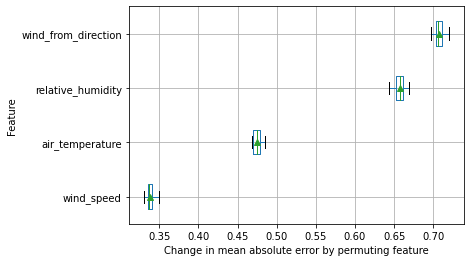

In [33]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in mean absolute error by permuting feature')
plt.show()

### Permutation importance on different height levels

Here we apply Breiman permutation importance to each height level to assess whether permuting a single height level affects the resulting precipitation prediction. The aim is to understand whether there are certain height levels and/or bands that may be more influencial. It is however worth being cautious with the interpretation here as permuation importance does not account for correlation between features, therefore the model may get the information lost by permuting a level from a different  which is well correlated, and the EDA showed that adjacent height levels tend to be well correlated. 

In [100]:
height_permutation_importance = {key:[] for key in feature_names}
for ifeature, feature in enumerate(feature_names):
    for ilevel in range(X_val_permute.shape[1]):
        X_val_permute = X_val.copy()
        X_val_permute[:, ilevel, ifeature] = np.take(X_val_permute[:, ilevel, ifeature], indices=np.random.permutation(X_val_permute.shape[0]), axis=0)
        y_pred = model.predict(X_val_permute)
        permuted_mae = metrics.mean_absolute_error(y_val, y_pred)
        height_permutation_importance[feature].append(permuted_mae - original_mae)

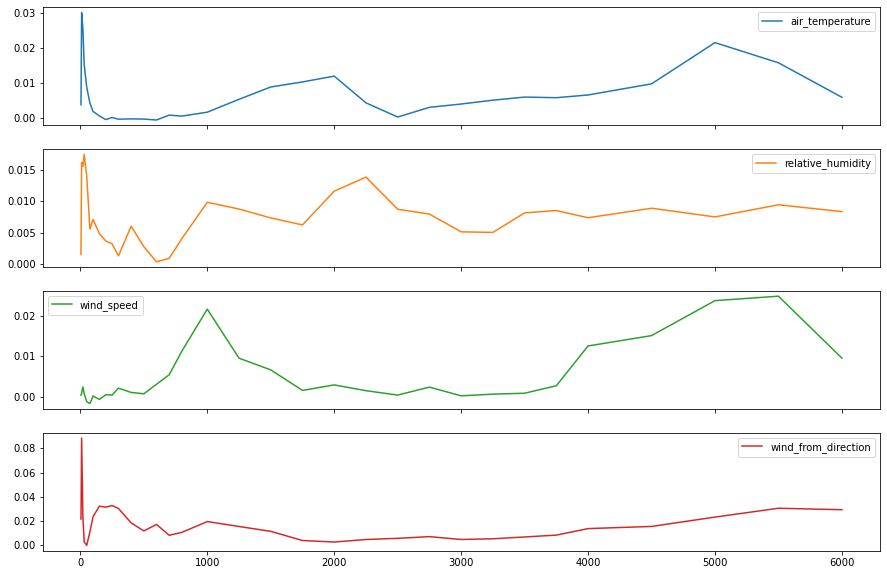

In [101]:
hpi_df = pd.DataFrame(height_permutation_importance, index=np.unique([float(string.split('_')[-1]) for string in prof_feature_columns]))
hpi_df.plot(subplots=True, figsize=(15,10))
plt.show()

### Permutation importance - Lakshmanan
 - In first round of Lakshmanan test, only one predictor is randomized at each step.
 - Thus, first round of Lakshmanan test = all of Breiman test.
 - At end of first round, the most important predictor (𝑥1) is permanently randomized.
 - In second round of Lakshmanan test, two predictors (𝑥1 and another) are randomized at each step.
 - At end of second round, the second-most important predictor (𝑥2) is permanently randomized.
 - Keeps going until all predictors are randomized.
 
<b>Currently doesn't work if single level features are included</b>

In [ ]:
remaining_feature_names = feature_names.copy()
current_step_num = 0

permuted_feature_name_by_step = []
highest_metric_by_step = []

In [ ]:
X_val_copy = X_val.copy()
while len(remaining_feature_names) > 0:
    current_step_num += 1

    highest_metric = -np.inf
    most_important_feature = None
    best_predictor_permuted_values = None

    for feature in remaining_feature_names:
        print(f'permuting feature "{feature}" at step {current_step_num}')
        feature_idx = feature_names.index(feature)
        print(feature_idx)
        X_val_permuted = X_val.copy()

        X_val_permuted[..., feature_idx] = np.take(
            X_val_permuted[..., feature_idx],
            indices=np.random.permutation(X_val_permuted.shape[0]), 
            axis=0)

        y_pred = model.predict(X_val_permuted)

        metric = metrics.mean_absolute_error(y_val, y_pred)
        print('Mean absolute error with permuted feature = {0:.4e}'.format(metric))

        if metric < highest_metric:
            continue

        highest_metric = metric
        most_important_feature = feature
        most_important_feature_permuted_values = X_val_permuted[..., feature_idx]

    permuted_feature_name_by_step.append(most_important_feature)
    highest_metric_by_step.append(highest_metric - original_mae)

    # Remove best predictor from list.
    remaining_feature_names.remove(most_important_feature)

    # Leave values of best predictor permuted.
    feature_idx = feature_names.index(most_important_feature)
    X_val_copy[..., feature_idx] = most_important_feature_permuted_values

    print('\nBest predictor = "{0:s}" ... new cost = {1:.4e}\n'.format(
        most_important_feature, highest_metric
    ))

In [ ]:
result_dict = {
        'feature_importance_order': permuted_feature_name_by_step, 
        'highest_mae_by_step': np.array(highest_metric_by_step), # The highest mean absolute error is how the most important feature is selected
        'original_mae': original_mae,
    }

In [ ]:
x_coords = np.concatenate((np.array([result_dict['original_mae']]), result_dict['highest_mae_by_step']))
y_strings = ['No permutation'] + result_dict['feature_importance_order']
y_coords = np.linspace(0, len(y_strings)-1, num=len(y_strings), dtype=float)[::-1]

In [ ]:
def _label_bars_in_graph(axes_object, y_coords, y_strings):
    """Labels bars in graph.

    J = number of bars

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :param y_coords: length-J numpy array with y-coordinates of bars.
    :param y_strings: length-J list of labels.
    """

    x_min, x_max = plt.xlim()
    x_coord_for_text = x_max - 0.01 * (x_max - x_min)

    for j in range(len(y_coords)):
        axes_object.text(
            x_coord_for_text, y_coords[j], y_strings[j], color='k',
            horizontalalignment='right', verticalalignment='center',
            fontsize='small', fontweight='bold')


In [ ]:
 _, axes_object = plt.subplots(1, 1, figsize=(10, 10))
axes_object.barh(y_coords, x_coords)
plt.yticks([], [])
plt.ylabel('Permuted features')
plt.xlabel('Change in mean absolute error by permuting feature')
_label_bars_in_graph(axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
plt.show()

## Evaluation

In [ ]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_val, y_pred, s=50, c='darkblue', label='ML pred', alpha=0.5)
plt.scatter(y_val, data.thickness_of_rainfall_amount[y_val.index]*1000, s=50, c='orange', label='NWP pred', alpha=0.5)
plt.gca().plot([0, 30], [0, 30], ls="--", c=".3")
plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()